# ECSE 415: Final Project
Mathieu Geoffroy, 260986559
Ryan Reszetnik, 260948454


December 5th, 2023

In [2]:
import numpy as np
import cv2
import os
from ultralytics import YOLO
import torch
from collections import defaultdict
import matplotlib.pyplot as plt

working_dir = os.path.curdir

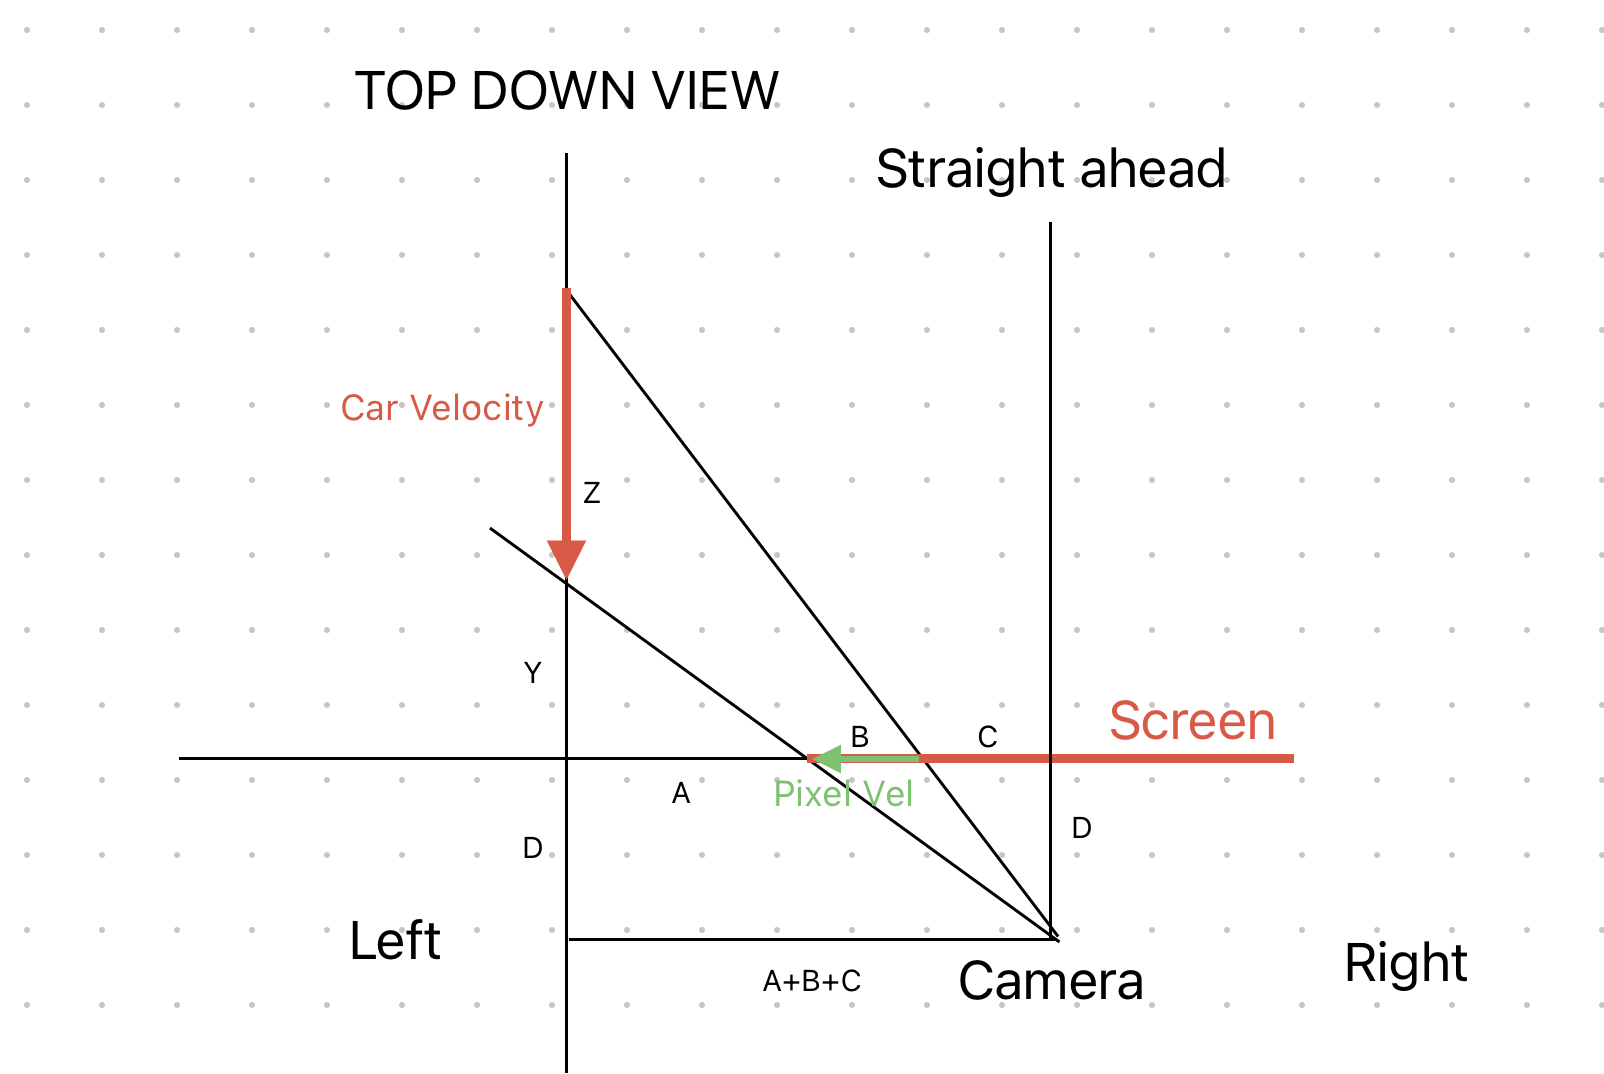


To calculate the speed of cars, we assume the math based on a top-down view as seen above. This assumes everything is at eye level and the same distance away from the car which is a simplification but seems to give good enough results.

Math to derrive equation used in code:

Want to find Z(B,C)
C = distance from centre of screen
B = velocity of object in pixels
Z = real object velocity


(D+Y)/(A+B+C)=D/(B+C)
D+Y = (A+B+C)*D/(B+C)
Y= (A+B+C)*D/(B+C)-D

(D+Y+Z)/(A+B+C) = D/C
Y+Z=(A+B+C)*D/C-D

Subtract two equations

Z=((A+B+C)*D/C-D) - ((A+B+C)*D/(B+C)-D)

Z= (A+B+C)*D/C-(A+B+C)*D/(B+C)

Z= (A+B+C)*D*(1/C-1/(B+C))
Z= (A+B+C)*D*B/(C(B+C))

A+B+C —> about equals A 

Z about proportional to: A*B/(C^2+CB)

assume A is constant however in theory could get in terms of distance

Z about proportional to: B/(C^2+CB) <= what we use in our code

## Detecitng moving vs parked

Now that we have an approximate speed for each object in the frame, we take all stationary objects and do a moving average to calculate an approximate speed (we start the speed at 30 as the car is moving to begin with in both videos). This is constantly updated every frame by both parked cars as well as fire hydrants as they don't move and are approximately eye level. To determine if a car is parked or moving, we check the speed of the car compared to the estimated speed. If its more than 1.5x the speed then it's classified as moving otherwise stopped. Any stopped cars go into calculating the speed for the next frame (moving average based on the current estimated speed and the speed of each object in the frame). Fire hydrants are weighted slightly more as they are known to be stopped.

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = YOLO('yolov8n.pt').to(device)

# import YOLO labels from the dataset
yolo_labels = model.names

FRAME_SIZE=  (1440, 2562) # (height, width)

In [4]:
def get_actual_speed(positions):
    new_pos = []
    for i in range(len(positions)):
        new_pos.append((positions[i][0].numpy(),positions[i][1].numpy()))
    new_pos = np.array(new_pos)
    speed = []
    for j in range(len(new_pos)-1):
        speed.append(np.sqrt((new_pos[j][0]-new_pos[j+1][0])**2+(new_pos[j][1]-new_pos[j+1][1])**2))
    speed = np.array(speed)
    new_pos = 1250-new_pos[:-1,0]
    speed = speed/(new_pos**2+abs(new_pos*speed)) * 1000000
    #median filter of size 3
    median_speed = []
    median_size = 5
    if len(speed) < median_size:
        return np.mean(speed)
    for i in range(len(speed)-median_size+1):
        median_speed.append(np.median(speed[i:i+median_size]))
    median_speed = np.array(median_speed)
    return np.mean(median_speed)


def is_moving(speed,predicted_speed):
    return speed > 1.5*predicted_speed



In [5]:
# Open the video file
def analyze_video(video_path, display=True, save=True):
    cap = cv2.VideoCapture(video_path)

    video_name = video_path.split('/')[-1].split('.')[0]
    
    out = cv2.VideoWriter(f'{video_name}_analyzed.mp4',cv2.VideoWriter_fourcc('m','p','4','v'), 30, (int(cap.get(3)),int(cap.get(4))))
    
    # Store the track history
    track_history = defaultdict(lambda: [])
    moving_history = defaultdict(lambda: [])
    
    people_count = 0

    predicted_speed = 30
    
    # Loop through the video frames
    frame_count = 0

    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()
        # print(frame.shape)
        # flow = calc_flow(prev_frame, frame)
        # print(flow.shape)
        frame_count += 1
        # if frame_count == 90:
        #     success = False
        print("frame count", frame_count)
        if success:
            # Run YOLOv8 tracking on the frame, persisting tracks between frames
 
            #disable the print statement in the track function
            results = model.track(frame, persist=True,verbose=False)
    
            # Get the boxes, masks, track IDs, class, for the frame
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            classes = results[0].boxes.cls.int().cpu().tolist()
            # Visualize the results on the frame
            annotated_frame = results[0].plot()
            
            # Plot the tracks
            for box,track_id,cls in zip(boxes, track_ids,classes):
                if yolo_labels[cls] == 'person' and track_id not in track_history:
                    people_count += 1
                x, y, w, h = box
                track = track_history[track_id]
                track.append((x, y))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)
                #detect if the bounding box is touching the edge of the frame   
                touching_edge =  x-w/2 <10 or x+w/2 > FRAME_SIZE[1] or y-h/2 < 0 or y+h/2 > FRAME_SIZE[0]
                obj_speed = get_actual_speed(track)
                if  yolo_labels[cls] == 'fire hydrant' and not np.isnan(obj_speed) and not touching_edge: 
                    predicted_speed = 29/30*predicted_speed + 1/30*obj_speed
                # set obj_speed to zero if it is Nan
                if np.isnan(obj_speed):
                    obj_speed = 0
                
                moving_pred = is_moving(obj_speed,predicted_speed)
                if yolo_labels[cls] == 'car':
                    moving_history[track_id]=moving_pred
                if obj_speed > 0 and not moving_pred and not np.isnan(obj_speed) and not touching_edge:
                    predicted_speed = 59/60*predicted_speed + 1/60*obj_speed
               
                text = "moving "+str(int(obj_speed)) if moving_pred else "stationary "+str(int(obj_speed))
                
                cv2.putText(annotated_frame, text, (int(x-w/2), int(y+h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
               
            num_moving = 0
            num_parked = 0
            for track_id in moving_history:
                if moving_history[track_id]:
                    num_moving += 1
                else:
                    num_parked += 1
            # Display the number of people
            cv2.putText(annotated_frame, f"Number of people: {people_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the number of moving cars
            cv2.putText(annotated_frame, f"Number of moving cars: {num_moving}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the number of parked cars
            cv2.putText(annotated_frame, f"Number of parked cars: {num_parked}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Display the predicted speed
            cv2.putText(annotated_frame, f"Speed: {predicted_speed} km/h", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Display the annotated frame
            cv2.imshow(f'Tracking {video_name}', annotated_frame) if display else None

            # save the annotated frame to a new video
            out.write(annotated_frame) if save else None
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break
    
    # Release the video capture object and close the display window
    cap.release()
    out.release()
    cv2.destroyAllWindows()    

In [6]:
analyze_video(working_dir + '/mcgill_drive.mp4', display=True, save=True)
# analyze_video(working_dir + '/st-catherines_drive.mp4', display=True, save=True)

frame count 1


KeyboardInterrupt: 

In [ ]:





# moving_ids = [
#     3,5,6,7,10,11,19,30,31,42,45,46,50,63,64,69,75,94,106,119,121,122,135,141,147,149
# ]
# stopped_ids = [
#     1,2,25,83,87,91,92,95,109,112,133,150,153,155,156,154
# ]

all_ids = object_positions.keys()
all_speeds = [get_actual_speed(object_positions[i]) for i in object_positions.keys()]

CUTOFF = 0.05


print(all_speeds)
print("MOVING")
for i in range(len(all_speeds)):
    if all_speeds[i] > CUTOFF:
        print(all_ids[i],all_speeds[i])

print("STOPPED")
for i in range(len(all_speeds)):
    if all_speeds[i] <= CUTOFF:
        print(all_ids[i],all_speeds[i])


# moving_speeds = [get_actual_speed(object_positions[i]) for i in moving_ids]
# stopped_speeds = [get_actual_speed(object_positions[i]) for i in stopped_ids]

# #get average speed of moving objects
# moving_speeds = np.array(moving_speeds)
# #get average speed of stopped objects
# stopped_speeds = np.array(stopped_speeds)

# print(moving_speeds,stopped_speeds)

# #plot the speed of moving objects
# plt.plot(moving_speeds)
# plt.title("Speed of moving objects")
# plt.xlabel("Frame")
# plt.ylabel("Speed (km/h)")
# plt.show()

# #plot the speed of stopped objects
# plt.plot(stopped_speeds)
# plt.title("Speed of stopped objects")
# plt.xlabel("Frame")
# plt.ylabel("Speed (km/h)")
# plt.show()
# #0.09 cutoff


# print(max(stopped_speeds),min(moving_speeds))
# print(moving_speeds)
